In [1]:
# install requirements
import sys
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !pip3 install transformers==4.15.0 timm==0.4.12 fairscale==0.4.4
    !git clone https://github.com/salesforce/BLIP
    %cd BLIP

Running in Colab.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
fatal: destination path 'BLIP' already exists and is not an empty directory.
/content/BLIP


### zero-shot image-text classification

In [2]:
from PIL import Image
import requests
import torch
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode

In [3]:
image_size = 384
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_retrieval_coco.pth'

In [4]:
urls = [
    "http://im.rediff.com/sports/2014/may/25fans4.jpg", # Emotion
    "https://m.media-amazon.com/images/I/615Kr5gtGhL._SL1500_.jpg", # inventory
    "https://i4.hurimg.com/i/hurriyet/75/866x494/632777c84e3fe1167045b304.jpg", # Brand
    "https://ichef.bbci.co.uk/food/ic/food_16x9_832/recipes/rib-eye_steak_with_61963_16x9.jpg" # Food 
    ]

In [5]:
# ground-truths are 4th. one in each list.
captions = [
            ["happy", "angry", "excited", "worried", "sad"],
            ["projector", "computer","screen", "printer", "calculator", "X-Box", "cartridge"],
            ["mercedes", "audio","bmw", "toyota", "honda", "alfa romeo", "chevrolet"],
            ["Salad", "Sandwich","Bread", "Steak", "Tuna Steak", "Fish", "Shrimp", "Rice"]
        ]

In [8]:
def load_demo_image(image_size,device, img_url):
    img_url = img_url
    raw_image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')   

    w,h = raw_image.size
    display(raw_image.resize((w//5,h//5)))
    
    transform = transforms.Compose([
        transforms.Resize((image_size,image_size),interpolation=InterpolationMode.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
        ]) 
    image = transform(raw_image).unsqueeze(0).to(device)   
    return image

## coco-base

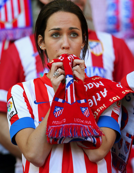

load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_retrieval_coco.pth
text: ['happy', 'angry', 'excited', 'worried', 'sad']
probability-itm-score: tensor([0.0050, 0.0460, 0.0700, 0.0460, 0.0330], grad_fn=<RoundBackward1>)
similarity-itc-score: tensor([[0.0980, 0.1980, 0.2210, 0.1920, 0.1760]], grad_fn=<RoundBackward1>)


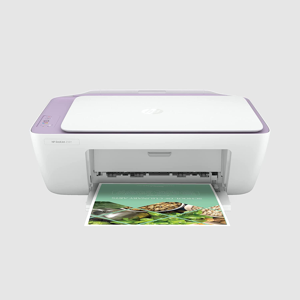

load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_retrieval_coco.pth
text: ['projector', 'computer', 'screen', 'printer', 'calculator', 'X-Box', 'cartridge']
probability-itm-score: tensor([0.0150, 0.0120, 0.0640, 0.7500, 0.0020, 0.0150, 0.0380],
       grad_fn=<RoundBackward1>)
similarity-itc-score: tensor([[0.2920, 0.3440, 0.2830, 0.4260, 0.2110, 0.1480, 0.2430]],
       grad_fn=<RoundBackward1>)


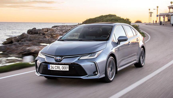

load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_retrieval_coco.pth
text: ['mercedes', 'audio', 'bmw', 'toyota', 'honda', 'alfa romeo', 'chevrolet']
probability-itm-score: tensor([0.0000, 0.0000, 0.0000, 0.6570, 0.0000, 0.0000, 0.0010],
       grad_fn=<RoundBackward1>)
similarity-itc-score: tensor([[0.2560, 0.1810, 0.2440, 0.3600, 0.2670, 0.2580, 0.3070]],
       grad_fn=<RoundBackward1>)


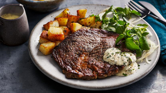

load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_retrieval_coco.pth
text: ['Salad', 'Sandwich', 'Bread', 'Steak', 'Tuna Steak', 'Fish', 'Shrimp', 'Rice']
probability-itm-score: tensor([0.0000, 0.0000, 0.0000, 0.6610, 0.0010, 0.0000, 0.0000, 0.0000],
       grad_fn=<RoundBackward1>)
similarity-itc-score: tensor([[0.2010, 0.2020, 0.1960, 0.3710, 0.2950, 0.1180, 0.1030, 0.1070]],
       grad_fn=<RoundBackward1>)


In [25]:
from models.blip_itm import blip_itm

for img_url, caption in zip(urls, captions):
    image = load_demo_image(image_size=image_size, device=device, img_url=img_url)
    model = blip_itm(pretrained=model_url, image_size=image_size, vit='base')
    model.eval()
    model = model.to(device='cpu')
    print('text: %s' %caption)
    itm_output = model(image,caption,match_head='itm')
    itm_score = torch.nn.functional.softmax(itm_output,dim=1)[:,1]
    print(f'probability-itm-score: {torch.round(itm_score,decimals=3)}')
    itc_score = model(image,caption,match_head='itc')
    print(f'similarity-itc-score: {torch.round(itc_score,decimals=3)}')
    print("=="*100)

**clip's results**

In [ ]:
# openai/clip-vit-large-patch14-336 prediction scores:

array([[0.003, 0.066, 0.02 , 0.901, 0.01 ]], dtype=float32)
array([[0.001, 0.   , 0.   , 0.998, 0.   , 0.   , 0.001]], dtype=float32)
array([[0.001, 0.001, 0.   , 0.995, 0.002, 0.   , 0.001]], dtype=float32)
array([[0.001, 0.   , 0.   , 0.994, 0.005, 0.   , 0.   , 0.   ]], dtype=float32)

## large-coco

In [9]:
model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_large_retrieval_coco.pth'

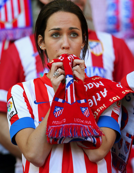

load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_large_retrieval_coco.pth
text: ['happy', 'angry', 'excited', 'worried', 'sad']
probability-itm-score: tensor([0.0840, 0.1410, 0.4380, 0.2110, 0.2060], grad_fn=<RoundBackward1>)
similarity-itc-score: tensor([[0.0630, 0.1680, 0.1720, 0.1830, 0.1340]], grad_fn=<RoundBackward1>)


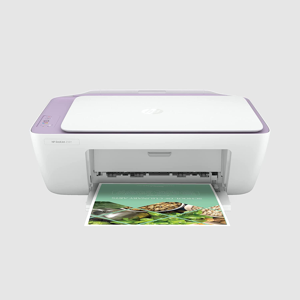

load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_large_retrieval_coco.pth
text: ['projector', 'computer', 'screen', 'printer', 'calculator', 'X-Box', 'cartridge']
probability-itm-score: tensor([0.0060, 0.1210, 0.0470, 0.8320, 0.0000, 0.0030, 0.0010],
       grad_fn=<RoundBackward1>)
similarity-itc-score: tensor([[0.2450, 0.2370, 0.1940, 0.3750, 0.1920, 0.1700, 0.2190]],
       grad_fn=<RoundBackward1>)


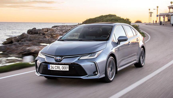

load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_large_retrieval_coco.pth
text: ['mercedes', 'audio', 'bmw', 'toyota', 'honda', 'alfa romeo', 'chevrolet']
probability-itm-score: tensor([0.0000, 0.0010, 0.0010, 0.5020, 0.0010, 0.0000, 0.0010],
       grad_fn=<RoundBackward1>)
similarity-itc-score: tensor([[0.2390, 0.1570, 0.2340, 0.3690, 0.2100, 0.2340, 0.2360]],
       grad_fn=<RoundBackward1>)


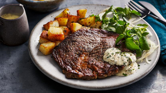

load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_large_retrieval_coco.pth
text: ['Salad', 'Sandwich', 'Bread', 'Steak', 'Tuna Steak', 'Fish', 'Shrimp', 'Rice']
probability-itm-score: tensor([0.0000, 0.0000, 0.0000, 0.2150, 0.0010, 0.0000, 0.0000, 0.0000],
       grad_fn=<RoundBackward1>)
similarity-itc-score: tensor([[0.1490, 0.1130, 0.0890, 0.3400, 0.3170, 0.1250, 0.0580, 0.1160]],
       grad_fn=<RoundBackward1>)


In [10]:
from models.blip_itm import blip_itm

for img_url, caption in zip(urls, captions):
    image = load_demo_image(image_size=image_size, device=device, img_url=img_url)
    model = blip_itm(pretrained=model_url, image_size=image_size, vit='large')
    model.eval()
    model = model.to(device='cpu')
    print('text: %s' %caption)
    itm_output = model(image,caption,match_head='itm')
    itm_score = torch.nn.functional.softmax(itm_output,dim=1)[:,1]
    print(f'probability-itm-score: {torch.round(itm_score,decimals=3)}')
    itc_score = model(image,caption,match_head='itc')
    print(f'similarity-itc-score: {torch.round(itc_score,decimals=3)}')
    print("=="*100)

## large-flickr

In [11]:
model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_large_retrieval_flickr.pth'

  0%|          | 0.00/3.43G [00:00<?, ?B/s]

load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_large_retrieval_flickr.pth


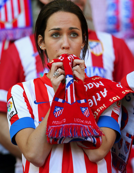

text: ['happy', 'angry', 'excited', 'worried', 'sad']
probability-itm-score: tensor([0.0320, 0.1080, 0.1230, 0.1780, 0.1270], grad_fn=<RoundBackward1>)
similarity-itc-score: tensor([[0.2330, 0.2800, 0.2780, 0.2880, 0.2370]], grad_fn=<RoundBackward1>)


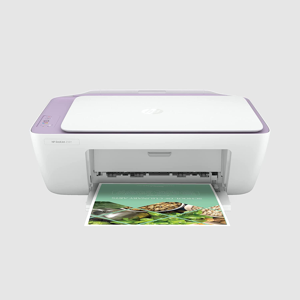

text: ['projector', 'computer', 'screen', 'printer', 'calculator', 'X-Box', 'cartridge']
probability-itm-score: tensor([0.0060, 0.0940, 0.0120, 0.9120, 0.0000, 0.0060, 0.0020],
       grad_fn=<RoundBackward1>)
similarity-itc-score: tensor([[0.3410, 0.3540, 0.3160, 0.4770, 0.2900, 0.2740, 0.3040]],
       grad_fn=<RoundBackward1>)


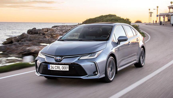

text: ['mercedes', 'audio', 'bmw', 'toyota', 'honda', 'alfa romeo', 'chevrolet']
probability-itm-score: tensor([0.0000, 0.0010, 0.0010, 0.7640, 0.0010, 0.0010, 0.0010],
       grad_fn=<RoundBackward1>)
similarity-itc-score: tensor([[0.3200, 0.2580, 0.3130, 0.4570, 0.2980, 0.3100, 0.3210]],
       grad_fn=<RoundBackward1>)


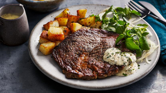

text: ['Salad', 'Sandwich', 'Bread', 'Steak', 'Tuna Steak', 'Fish', 'Shrimp', 'Rice']
probability-itm-score: tensor([0.0000, 0.0000, 0.0000, 0.4710, 0.0080, 0.0000, 0.0000, 0.0000],
       grad_fn=<RoundBackward1>)
similarity-itc-score: tensor([[0.2290, 0.1880, 0.1790, 0.4340, 0.3910, 0.2390, 0.1920, 0.2160]],
       grad_fn=<RoundBackward1>)


In [12]:
from models.blip_itm import blip_itm

model = blip_itm(pretrained=model_url, image_size=image_size, vit='large')
model.eval()
model = model.to(device='cpu')

for img_url, caption in zip(urls, captions):
    image = load_demo_image(image_size=image_size, device=device, img_url=img_url)
    print('text: %s' %caption)
    itm_output = model(image,caption,match_head='itm')
    itm_score = torch.nn.functional.softmax(itm_output,dim=1)[:,1]
    print(f'probability-itm-score: {torch.round(itm_score,decimals=3)}')
    itc_score = model(image,caption,match_head='itc')
    print(f'similarity-itc-score: {torch.round(itc_score,decimals=3)}')
    print("=="*100)

# Image Captioning
Perform image captioning using finetuned BLIP model

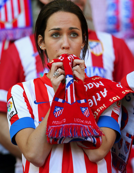

  0%|          | 0.00/1.97G [00:00<?, ?B/s]

reshape position embedding from 196 to 576
load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_capfilt_large.pth
caption: a atletico fan


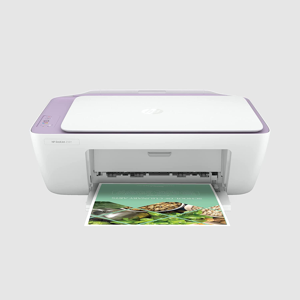

reshape position embedding from 196 to 576
load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_capfilt_large.pth
caption: the hp desk printer


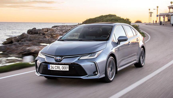

reshape position embedding from 196 to 576
load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_capfilt_large.pth
caption: the toyota coroll on the road


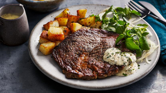

reshape position embedding from 196 to 576
load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_capfilt_large.pth
caption: a steak steak with potatoes and herbs on a plate


In [26]:
from models.blip import blip_decoder
model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_capfilt_large.pth'


for img_url in urls:
    image = load_demo_image(image_size=image_size, device=device, img_url=img_url)
    model = blip_decoder(pretrained=model_url, image_size=image_size, vit='base')
    model.eval()
    model = model.to(device)

    with torch.no_grad():
        # beam search
        caption = model.generate(image, sample=False, num_beams=3, max_length=20, min_length=5) 
        # nucleus sampling
        # caption = model.generate(image, sample=True, top_p=0.9, max_length=20, min_length=5) 
        print('caption: '+caption[0])
        print("=="*100)